In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

In [2]:
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

#to return a list of all tables and views in our database.  To check the state of our database as we work.        
def show_tables():
    q='''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(q)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [4]:
albums_to_purchase = '''
With USA_tracks_sold AS
    (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on c.customer_id = i.customer_id
    WHERE c.country = "USA"
    )

SELECT 
    g.name genre,
    COUNT(uts.invoice_line_id) tracks_sold,
    CAST(COUNT(uts.invoice_line_id) AS float) / (SELECT COUNT (*) from usa_tracks_sold) percentage_sold
FROM USA_tracks_sold uts
INNER JOIN track t ON t.track_id = uts.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY genre
ORDER BY tracks_sold desc;

'''
run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


AttributeError: 'module' object has no attribute 'annotate'

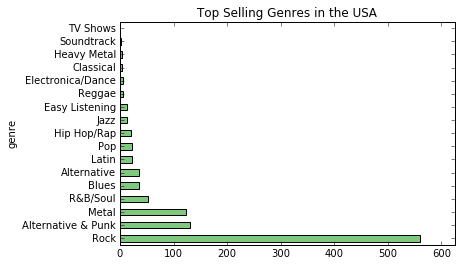

In [7]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()